# Basic Disturbing Function Integration
This notebook illustrates some of the basic elements of initializing and running integrations with celmech's 'PoincareHamiltonian'. The package is designed to construct a Hamiltonian and integrate equations of motion using a collection of user-specified disturbing function terms.

In [1]:
from celmech import Poincare
import rebound

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# sympy for pretty printing, symbolic manipulation
from sympy import init_printing
init_printing()

## Set up a REBOUND integration

Set up a REBOUND simulation of three planets

In [8]:
import rebound

def get_sim_res(j,k):
    sim = rebound.Simulation()
    sim.add(m=1)
 
    sim.G = 4*np.pi*np.pi
    mass=1e-8
    
    sim.add(m=mass,e=0.002,P=1)
    sim.add(m=mass,P=j / float(j-k),e=0.005)
    
    sim.dt = sim.particles[1].P / 30.
    sim.integrator='whfast'
    return sim 

In [4]:
import rebound
from random import random, seed
from celmech import Poincare, PoincareHamiltonian

def get_sim(Nseed):
    seed(Nseed)
    sim = rebound.Simulation()
    sim.add(m=1)
 
    sim.G = 4*np.pi*np.pi
    a1 = 1
    m1 = 10**(6*random()-10) # uniform in log space between 10**[-10, -4]
    m2 = 10**(6*random()-10)
    print(m1, m2)
    RH = a1*((m1+m2)/3.)**(1./3.)
    beta = 10#4 + 6*random() # uniform on [4, 10] mutual hill radii separation
    print(beta)
    sim.add(m=m1,a=a1)
    sim.add(m=m2,a=a1+beta*RH, theta=np.pi/3)
    sim.dt = sim.particles[1].P / 30.
    sim.integrator='whfast'
    if sim.particles[1].a/sim.particles[2].a > 0.98:
        return get_sim()
    return sim 

In [5]:
%run -i ../ResonanceLocationsAndWidths.py

6.400080914317189e-10 1.2150731428549984e-05
10
pratio =  0.801032260789887
17 : 12 10.1633565538
7 : 5 3.81531238633
18 : 13 8.91320537781
11 : 8 5.09789299149
15 : 11 6.38047359664
19 : 14 7.6630542018
4 : 3 1.28258060516
21 : 16 5.16275184979
17 : 13 3.88017124463
13 : 10 2.59759063947
22 : 17 3.91260067378
9 : 7 1.31501003431
23 : 18 2.66244949777
14 : 11 1.34743946346
19 : 15 1.37986889261
24 : 19 1.41229832176
5 : 4 0.0324294291514
26 : 21 -1.08800403025
21 : 17 -1.1204334594
16 : 13 -1.15286288855
27 : 22 -2.33815520626
11 : 9 -1.18529231771
28 : 23 -3.58830638227
17 : 14 -2.40301406456
23 : 19 -3.62073581142
29 : 24 -4.83845755827
6 : 5 -1.21772174686
31 : 26 -7.33875991029
25 : 21 -6.12103816343
19 : 16 -4.90331641658
32 : 27 -8.5889110863
13 : 11 -3.68559466972
33 : 28 -9.83906226231
20 : 17 -6.15346759258
27 : 23 -8.62134051545
34 : 29 -11.0892134383
7 : 6 -2.46787292286
36 : 31 -13.5895157903
29 : 25 -11.1216428675
22 : 19 -8.6537699446
37 : 32 -14.8396669663
15 : 13 -6.185

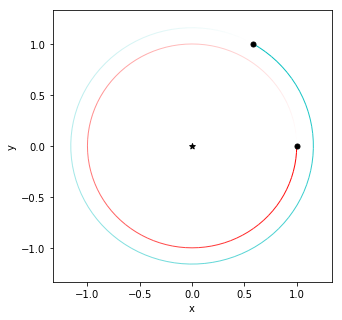

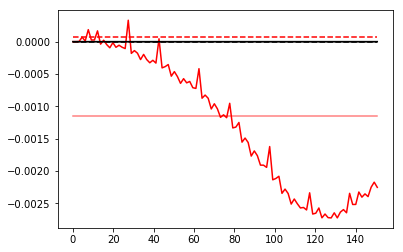

In [11]:
sim = get_sim(1)
ps = sim.particles

pratio = ps[1].P/ps[2].P
print('pratio = ', pratio)
res = resonant_period_ratios(pratio-0.1, pratio+0.1, 5)
ps = sim.particles
for r in res:
    j = r[1]
    k = r[1]-r[0]
    print(j, ':', j-k, j*ps[2].n-(j-k)*ps[1].n)
print('***')               
               
rebound.plotting.OrbitPlot(sim,color=True);
a10 = ps[1].a
a20 = ps[2].a
poincare_variables = Poincare.from_Simulation(sim, average_synodic_terms=True)
Hp = PoincareHamiltonian(poincare_variables)

#print(ps[1].m, ps[2].m)
tsyn = 2*np.pi/(ps[1].n-ps[2].n)
#print(tsyn)
tmax = 30*tsyn
Nout = 100
times = np.linspace(0, tmax, Nout)

Nsma = np.zeros((2,Nout))
Hsma = np.zeros((2,Nout))

for i,t in enumerate(times):
    # Store N-body data
    Nsma[0,i]=ps[1].a
    Nsma[1,i]=ps[2].a
    
    #  Convert the Poincare variables back to rebound simulation to store a's and e's
    simP=Hp.state.to_Simulation()
    Hsma[0,i]=simP.particles[1].a
    Hsma[1,i]=simP.particles[2].a
    
    # integrate the N-body simulation
    sim.integrate(t)
    Hp.integrate(t)
    # integration Poincare simulation
    
Nmed1 = np.median((Nsma[0]-a10)/a10)
Pmed1 = np.median((Hsma[0]-a10)/a10)
print(abs(Pmed1-Nmed1)/Nmed1)
Nmed2 = np.median((Nsma[1]-a20)/a20)
Pmed2 = np.median((Hsma[1]-a20)/a20)
print(abs(Pmed2-Nmed2)/Nmed2)
fig,ax=plt.subplots()

ax.plot(times,(Hsma[0]-a10)/a10,'r--')
ax.plot(times,(Hsma[1]-a20)/a20,'k--')

ax.plot(times,(Nsma[0]-a10)/a10,'r')
ax.plot(times,(Nsma[1]-a20)/a20,'k')

ax.plot(times,[Nmed1]*len(times),'r', alpha=0.5)
ax.plot(times,[Nmed2]*len(times),'k', alpha=0.5)

In [7]:
import rebound
from random import random, seed
from celmech import Poincare, PoincareHamiltonian
seed(0)
def get_sim():
    print('getting')
    sim = rebound.Simulation()
    sim.add(m=1)
 
    sim.G = 4*np.pi*np.pi
    a1 = 1
    m1 = 10**(2*random()-10) # uniform in log space between 10**[-10, -4]
    m2 = 10**(2*random()-10)
    sim.add(m=m1,P=2*np.pi)
    sim.add(m=m2,P=sim.particles[1].P*20/19, theta=np.pi/3)
    sim.dt = sim.particles[1].P / 30.
    sim.integrator='whfast'
    if sim.particles[1].a/sim.particles[2].a > 0.98:
        return get_sim()
    return sim 

getting
pratio =  0.9500000000000001
***
prefac, alpha, cos(deltalambda), summation, lpc/2, s
3.40226138771e-16 0.966382530044 0.5 1.01665048172 1.7662357072737505 4.19422785355e-16
0.0 1.0471975511965976 -1.0471975511965976
Adding 7:6 resonance terms for planets 1 and 2
-1.63669193926
1.44043215775


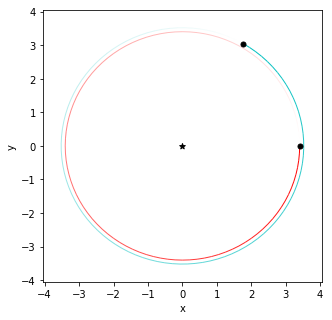

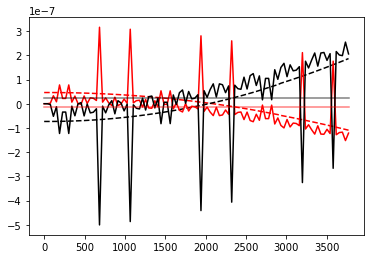

In [9]:
sim = get_sim()
ps = sim.particles

pratio = ps[1].P/ps[2].P
print('pratio = ', pratio)
res = resonant_period_ratios(pratio-0.1, pratio+0.1, 5)
ps = sim.particles
for r in res:
    j = r[1]
    k = r[1]-r[0]
    print(j*ps[2].n-(j-k)*ps[1].n)
print('***')               
               
rebound.plotting.OrbitPlot(sim,color=True);
a10 = ps[1].a
a20 = ps[2].a
poincare_variables = Poincare.from_Simulation(sim, average_synodic_terms=True)
Hp = PoincareHamiltonian(poincare_variables)

print("Adding %d:%d resonance terms for planets %d and %d"%(7,6,1,2))
Hp.add_all_resonance_subterms(1,2,20,1)

#print(ps[1].m, ps[2].m)
tsyn = 2*np.pi/(ps[1].n-ps[2].n)
#print(tsyn)
tmax = 30*tsyn
Nout = 100
times = np.linspace(0, tmax, Nout)

Nsma = np.zeros((2,Nout))
Hsma = np.zeros((2,Nout))

for i,t in enumerate(times):
    # Store N-body data
    Nsma[0,i]=ps[1].a
    Nsma[1,i]=ps[2].a
    
    #  Convert the Poincare variables back to rebound simulation to store a's and e's
    simP=Hp.state.to_Simulation()
    Hsma[0,i]=simP.particles[1].a
    Hsma[1,i]=simP.particles[2].a
    
    # integrate the N-body simulation
    sim.integrate(t)
    Hp.integrate(t)
    # integration Poincare simulation
    
Nmed1 = np.median((Nsma[0]-a10)/a10)
Pmed1 = np.median((Hsma[0]-a10)/a10)
print(abs(Pmed1-Nmed1)/Nmed1)
Nmed2 = np.median((Nsma[1]-a20)/a20)
Pmed2 = np.median((Hsma[1]-a20)/a20)
print(abs(Pmed2-Nmed2)/Nmed2)
fig,ax=plt.subplots()

ax.plot(times,(Hsma[0]-a10)/a10,'r--')
ax.plot(times,(Hsma[1]-a20)/a20,'k--')

ax.plot(times,(Nsma[0]-a10)/a10,'r')
ax.plot(times,(Nsma[1]-a20)/a20,'k')

ax.plot(times,[Nmed1]*len(times),'r', alpha=0.5)
ax.plot(times,[Nmed2]*len(times),'k', alpha=0.5)

In [37]:
Nmed

NameError: name 'Nmed' is not defined

In [8]:
Pmed

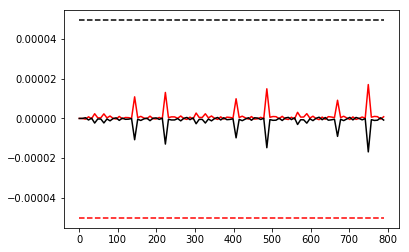

In [53]:
fig,ax=plt.subplots()

ax.plot(times,(Hsma[0]-a10)/a10,'r--')
ax.plot(times,(Hsma[1]-a20)/a20,'k--')

ax.plot(times,(Nsma[0]-a10)/a10,'r')
ax.plot(times,(Nsma[1]-a20)/a20,'k')

In [16]:
from celmech.disturbing_function import laplace_coefficient

# should I rmeove j=0 term? pretty substantial

In [24]:
laplace_coefficient(0.5, 0, 0, 0.01)/2.

In [128]:
alpha = 0.95
dl = 3.4
lim = 100
tot=0
for j in np.arange(-lim, lim+1):
    tot += laplace_coefficient(0.5, j, 0, alpha)*np.cos(j*dl)
tot /= 2.
sumval = (1 + alpha**2 - 2*alpha*np.cos(dl))**(-0.5)
print(tot, sumval)

0.517811719832 0.517128027146


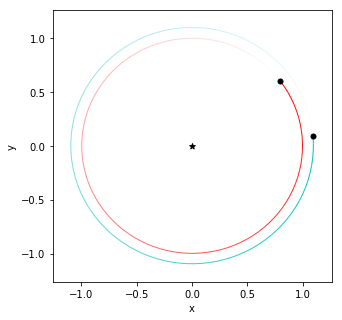

In [158]:
rebound.plotting.OrbitPlot(sim,color=True);

Get a simulation with inner pair near a 3:2 mean-motion resonance

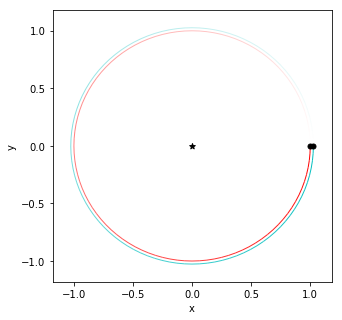

In [121]:
resonance, res_order =13,2
sim=get_sim(1.04)
rebound.plotting.OrbitPlot(sim,color=True);

## Make a celmech model 

Import Poincare variable functions from the celmech package

In [122]:
from celmech import Poincare, PoincareHamiltonian

Initialize model directly from the REBOUND simulation

In [123]:
a10 = sim.particles[1].a
a20 = sim.particles[2].a

In [124]:
poincare_variables = Poincare.from_Simulation(sim, average_synodic_terms=True)

A 'Poincare' object stores a set of particles with canonical coordinates:
\begin{align}
\Lambda_i = m_i\sqrt{G M_* a_i} &;& \lambda_i \\
X_i = \sqrt{2\Gamma_i}\cos(\gamma_i) &;& Y_i=\sqrt{2\Gamma_i}\sin(\gamma_i)
\end{align}
where 
\begin{align}
\Gamma_i = \Lambda_i(1-\sqrt{1-e_i^2}) &;& \gamma_i =-\varpi_i 
\end{align}

In [125]:
for i,p in enumerate(poincare_variables.particles[1:]):
    print("Lambda_%d = %.3g , Gamma_%d = %.3g"%(i,p.Lambda,i, p.Gamma))

Lambda_0 = 9.41e-06 , Gamma_0 = 0
Lambda_1 = 9.56e-06 , Gamma_1 = 0


Now construct a Hamiltonian model with the Poincare varaibles:

In [126]:
Hp = PoincareHamiltonian(poincare_variables)

The 'Hamlitonian' object keeps track of a symbolic Hamiltonian.
By default $N$ distinct Keplerian terms are included.

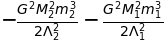

In [127]:
Hp.H

The numerical value of all parameters is tracked as well:

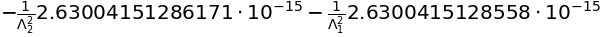

In [128]:
Hp.NH

## Add the disturbing function terms associated with the 3:2 resonance
The "add_all_resonance_subterms" adds the disturbing function terms
\begin{equation}
\text{3:2 terms}=C_{3,1,0} e'\cos[3\lambda'-2\lambda-\varpi'] + C_{3,1,1} e\cos[3\lambda'-2\lambda-\varpi]
\end{equation}
to the Hamiltonian in canonical coordinates.

Celmech can add terms for any $k$th order resonance as
\begin{equation}
\text{j:(j-k) terms}=\sum_{l=0}^{k} C_{j,k,l}e^{l}e'^{k-l}\cos[j\lambda'-(j-k)\lambda-l\varpi-(k-l)\varpi'] 
\end{equation}

In [43]:
inner_planet=1
outer_planet=2
print("Adding %d:%d resonance terms for planets %d and %d"%(resonance,resonance-res_order,inner_planet,outer_planet))

# Call to celmech to add terms
Hp.add_all_resonance_subterms(inner_planet,outer_planet, resonance,res_order)

Adding 13:11 resonance terms for planets 1 and 2


The symbolic Hamiltonian now reflects the new terms:

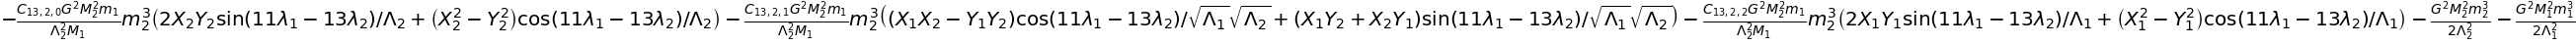

In [44]:
Hp.H

An auxilary 'Hpolar' expressed in terms of $\Gamma_i,\gamma_i$ is also stored (this is often more readable):

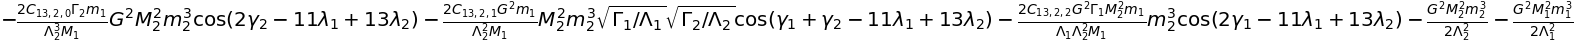

In [26]:
Hp.Hpolar

# Integrate the system and compare with the  REBOUND $N$-body results:
'PoincareHamiltonian.state' keeps track of the 'Poincare' variables that can easily be converted back to a REBOUND simulation for direct comparison of orbital elements

In [129]:
Norbits = 6e1
Nout = 1000

tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout)

Nsma = np.zeros((2,Nout))
Necc = np.zeros((2,Nout))
Psma = np.zeros((2,Nout))
Pecc = np.zeros((2,Nout))

for i,t in enumerate(times):
    # Store N-body data
    Nsma[0,i]=sim.particles[1].a
    Nsma[1,i]=sim.particles[2].a
    Necc[0,i]=sim.particles[1].e
    Necc[1,i]=sim.particles[2].e

    #  Convert the Poincare variables back to rebound simulation to store a's and e's
    simP=Hp.state.to_Simulation()
    Psma[0,i]=simP.particles[1].a
    Psma[1,i]=simP.particles[2].a
    Pecc[0,i]=simP.particles[1].e
    Pecc[1,i]=simP.particles[2].e

    # integrate the N-body simulation
    sim.integrate(times[i])
    # integration Poincare simulation
    Hp.integrate(times[i])

In [130]:
Nmed = np.median((Nsma[0]-a10)/a10)
Pmed = np.median((Psma[0]-a10)/a10)
abs(Pmed-Nmed)/Nmed

In [131]:
Pmed, Nmed

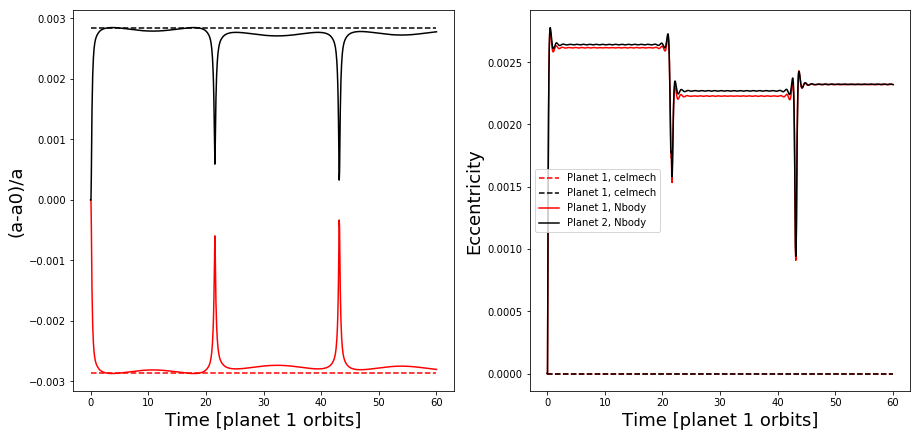

In [132]:
fig,ax=plt.subplots(1,2,figsize=(15,7))

ax[0].plot(times,(Psma[0]-a10)/a10,'r--')
ax[0].plot(times,(Psma[1]-a20)/a20,'k--')

ax[0].plot(times,(Nsma[0]-a10)/a10,'r')
ax[0].plot(times,(Nsma[1]-a20)/a20,'k')

ax[1].plot(times,Pecc[0],'r--',label='Planet 1, celmech')
ax[1].plot(times,Pecc[1],'k--',label='Planet 1, celmech')

ax[1].plot(times,Necc[0],'r',label='Planet 1, Nbody')
ax[1].plot(times,Necc[1],'k',label='Planet 2, Nbody')
ax[1].legend()

ax[0].set_ylabel('(a-a0)/a',fontsize=18)
ax[1].set_ylabel('Eccentricity',fontsize=18)

ax[0].set_xlabel('Time [planet 1 orbits]',fontsize=18)
ax[1].set_xlabel('Time [planet 1 orbits]',fontsize=18)

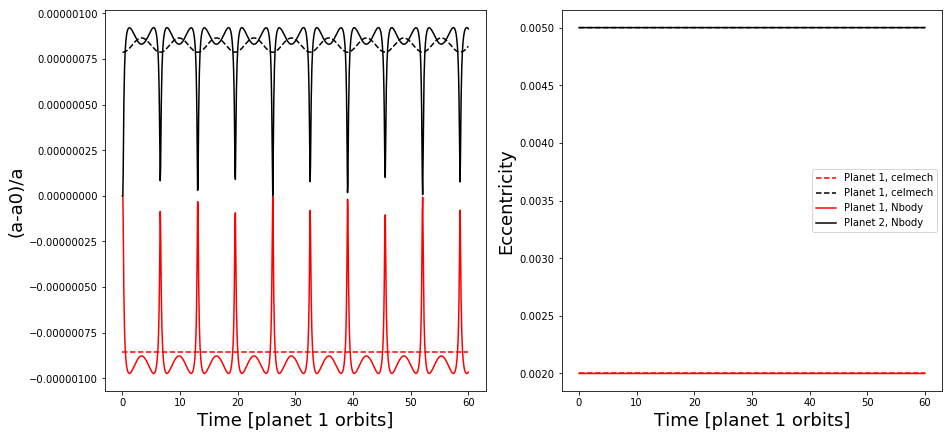

In [16]:
fig,ax=plt.subplots(1,2,figsize=(15,7))

ax[0].plot(times,(Psma[0]-a10)/a10,'r--')
ax[0].plot(times,(Psma[1]-a20)/a20,'k--')

ax[0].plot(times,(Nsma[0]-a10)/a10,'r')
ax[0].plot(times,(Nsma[1]-a20)/a20,'k')

ax[1].plot(times,Pecc[0],'r--',label='Planet 1, celmech')
ax[1].plot(times,Pecc[1],'k--',label='Planet 1, celmech')

ax[1].plot(times,Necc[0],'r',label='Planet 1, Nbody')
ax[1].plot(times,Necc[1],'k',label='Planet 2, Nbody')
ax[1].legend()

ax[0].set_ylabel('(a-a0)/a',fontsize=18)
ax[1].set_ylabel('Eccentricity',fontsize=18)

ax[0].set_xlabel('Time [planet 1 orbits]',fontsize=18)
ax[1].set_xlabel('Time [planet 1 orbits]',fontsize=18)

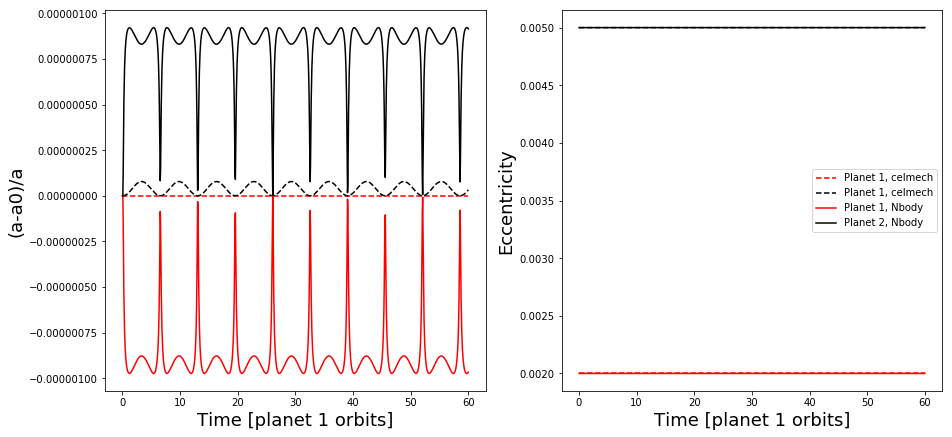

In [17]:
fig,ax=plt.subplots(1,2,figsize=(15,7))

ax[0].plot(times,(Psma[0]-Psma[0,0])/Psma[0,0],'r--')
ax[0].plot(times,(Psma[1]-Psma[1,0])/Psma[1,0],'k--')

ax[0].plot(times,(Nsma[0]-Nsma[0,0])/Nsma[0,0],'r')
ax[0].plot(times,(Nsma[1]-Nsma[1,0])/Nsma[1,0],'k')

ax[1].plot(times,Pecc[0],'r--',label='Planet 1, celmech')
ax[1].plot(times,Pecc[1],'k--',label='Planet 1, celmech')

ax[1].plot(times,Necc[0],'r',label='Planet 1, Nbody')
ax[1].plot(times,Necc[1],'k',label='Planet 2, Nbody')
ax[1].legend()

ax[0].set_ylabel('(a-a0)/a',fontsize=18)
ax[1].set_ylabel('Eccentricity',fontsize=18)

ax[0].set_xlabel('Time [planet 1 orbits]',fontsize=18)
ax[1].set_xlabel('Time [planet 1 orbits]',fontsize=18)

# Investigate adding more terms
Let's include higher harmonics of the 3:2 MMR along and secular terms and secular interactions between all the planets

In [57]:
secular_order = 2
sim=get_sim(resonance, res_order)
poincare_variables = Poincare.from_Simulation(sim, average_synodic_terms=True)
Hp = PoincareHamiltonian(poincare_variables)
for i in range(1,4):
    j,k = i*resonance,i*(res_order)
    print("Adding %d:%d resonance terms for planets %d and %d"%(j,j-k,inner_planet,outer_planet))
    Hp.add_all_resonance_subterms(inner_planet,outer_planet,j,k)
for i in range(1,Hp.state.N):
    for j in range(i+1,Hp.state.N):
        print("Adding secular terms to order %d for planets %d and %d"%(secular_order,i,j))
        Hp.add_secular_terms(i,j,secular_order)

0.0309021060975
Adding 13:11 resonance terms for planets 1 and 2
Adding 26:22 resonance terms for planets 1 and 2
Adding 39:33 resonance terms for planets 1 and 2
Adding secular terms to order 2 for planets 1 and 2
Computing secular expansion to order 2...


In [58]:
Norbits = 6e1
Nout = 1000

tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout)

Nsma = np.zeros((2,Nout))
Necc = np.zeros((2,Nout))
Psma = np.zeros((2,Nout))
Pecc = np.zeros((2,Nout))

for i,t in enumerate(times):
    # Store N-body data
    Nsma[0,i]=sim.particles[1].a
    Nsma[1,i]=sim.particles[2].a
    Necc[0,i]=sim.particles[1].e
    Necc[1,i]=sim.particles[2].e

    #  Convert the Poincare variables back to rebound simulation to store a's and e's
    simP=Hp.state.to_Simulation()
    Psma[0,i]=simP.particles[1].a
    Psma[1,i]=simP.particles[2].a
    Pecc[0,i]=simP.particles[1].e
    Pecc[1,i]=simP.particles[2].e

    # integrate the N-body simulation
    sim.integrate(times[i])
    # integration Poincare simulation
    Hp.integrate(times[i])



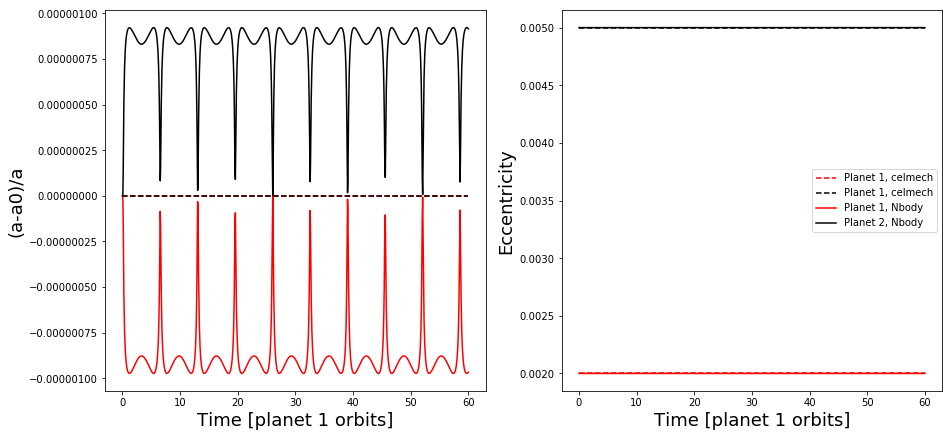

In [59]:
fig,ax=plt.subplots(1,2,figsize=(15,7))

ax[0].plot(times,(Psma[0]-Psma[0,0])/Psma[0,0],'r--')
ax[0].plot(times,(Psma[1]-Psma[1,0])/Psma[1,0],'k--')

ax[0].plot(times,(Nsma[0]-Nsma[0,0])/Nsma[0,0],'r')
ax[0].plot(times,(Nsma[1]-Nsma[1,0])/Nsma[1,0],'k')

ax[1].plot(times,Pecc[0],'r--',label='Planet 1, celmech')
ax[1].plot(times,Pecc[1],'k--',label='Planet 1, celmech')

ax[1].plot(times,Necc[0],'r',label='Planet 1, Nbody')
ax[1].plot(times,Necc[1],'k',label='Planet 2, Nbody')
ax[1].legend()

ax[0].set_ylabel('(a-a0)/a',fontsize=18)
ax[1].set_ylabel('Eccentricity',fontsize=18)

ax[0].set_xlabel('Time [planet 1 orbits]',fontsize=18)
ax[1].set_xlabel('Time [planet 1 orbits]',fontsize=18)